In [2]:
import pandas as pd

df = pd.read_csv('../../Output/output_1.csv')
df = pd.concat([
    pd.read_csv(F'../../Output/output_{i}.csv').drop(columns=[x for x in df.columns if 'id' in x]) 
    for i in range(1, 12)])

df.head()

,x,y,z,type,1-neighbour type,1-neighbour x,1-neighbour y,1-neighbour z,2-neighbour type,2-neighbour x,...,4-faced,5-faced,6-faced,7-faced,8-faced,9-faced,10-faced,11-faced,12-faced,13-faced
0,26.0291,54.9202,24.4540,1.28,1.28,26.7424,53.8812,22.4257,1.60,23.7794,...,1.0,3.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42.4982,36.7826,37.0707,1.60,1.28,44.2310,38.3539,35.8460,1.28,40.5901,...,0.0,1.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44.3755,24.9085,17.9155,1.60,1.28,43.8712,22.7444,16.3405,1.28,41.8245,...,1.0,1.0,9.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
3,53.9179,13.2666,54.6982,1.28,1.28,51.7705,14.4300,53.9390,1.28,52.5371,...,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30.7815,28.6099,25.9021,1.28,1.28,31.8357,30.5916,25.3170,1.28,28.2009,...,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.shape

(148500, 98)

In [47]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [48]:
data = df.to_numpy()
data = data.astype(np.float32)

inp_data_train, inp_data_test, out_data_train, out_data_test = train_test_split(
    data[:, :-14], data[:, -14:], test_size=0.2, random_state=123)

inp_data_test, inp_data_valid, out_data_test, out_data_valid = train_test_split(
    inp_data_test, out_data_test, test_size=0.5, random_state=123)

inp_data_test , out_data_test  = \
    torch.from_numpy(inp_data_test) , torch.from_numpy(out_data_test)

inp_data_train, out_data_train = \
    torch.from_numpy(inp_data_train), torch.from_numpy(out_data_train)

inp_data_valid, out_data_valid = \
    torch.from_numpy(inp_data_valid), torch.from_numpy(out_data_valid)

In [49]:
train_dataset = TensorDataset(inp_data_train, out_data_train)
valid_dataset = TensorDataset(inp_data_valid, out_data_valid)
test_dataset  = TensorDataset(inp_data_test , out_data_test )

In [50]:
BATCH_SIZE = 256 # todo: more stable updating model parameters.

In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [52]:
import torch.nn as nn
import torch.nn.functional as nf

class RegressionMultiout(nn.Module):
    def __init__(self, inputs_size, hidden_size, output_size):
        super(RegressionMultiout, self).__init__()
        
        self.vorono = nn.Sequential(
            nn.Linear(inputs_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            # todo: add for more complex model.
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        
        self.init_weights()
        
    def init_weights(self):
        
        def inner_init_weights(layer):
            if not isinstance(layer, nn.Linear):
                return
            
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.constant_(layer.bias.data, 0.1)
            
        self.vorono.apply(inner_init_weights)

        
    def forward(self, x):
        return self.vorono(x)

In [53]:
# todo: change HIDDEN_SIZE for more complex model. (less overfit and loss. more epoch is needed!)
INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE = inp_data_train.shape[1], 35, out_data_train.shape[1]

In [54]:
model = RegressionMultiout(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model

RegressionMultiout(
  (vorono): Sequential(
    (0): Linear(in_features=84, out_features=35, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=35, out_features=35, bias=True)
    (4): ReLU()
    (5): Linear(in_features=35, out_features=14, bias=True)
  )
)

In [55]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

num_epochs = 300
batch_size_train = len(train_loader)
batch_size_valid = len(valid_loader)

criterion = torch.nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=5e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9) 

005.learning_rate: 0.00500
005.running_loss: 1.18781
010.learning_rate: 0.00450
010.running_loss: 1.07537
015.learning_rate: 0.00450
015.running_loss: 1.04642
020.learning_rate: 0.00405
020.running_loss: 1.03287
025.learning_rate: 0.00405
025.running_loss: 1.01988
030.learning_rate: 0.00365
030.running_loss: 1.02038
035.learning_rate: 0.00365
035.running_loss: 1.00137
040.learning_rate: 0.00328
040.running_loss: 1.00479
045.learning_rate: 0.00328
045.running_loss: 0.99712
050.learning_rate: 0.00295
050.running_loss: 1.00204
055.learning_rate: 0.00295
055.running_loss: 0.97865
060.learning_rate: 0.00266
060.running_loss: 0.97805
065.learning_rate: 0.00266
065.running_loss: 0.97306
070.learning_rate: 0.00239
070.running_loss: 0.97522
075.learning_rate: 0.00239
075.running_loss: 0.96514
080.learning_rate: 0.00215
080.running_loss: 0.97259
085.learning_rate: 0.00215
085.running_loss: 0.96950
090.learning_rate: 0.00194
090.running_loss: 0.96312
095.learning_rate: 0.00194
095.running_loss: 0

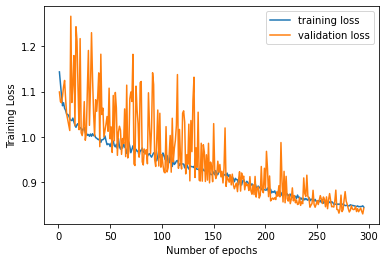

In [56]:
import matplotlib.pyplot as plt

train_loss = []
validation_loss = []

for epoch in range(1, num_epochs + 1):
    
    running_loss = 0
    for inp_train, out_train in train_loader:
        
        prediction = model(inp_train)
        loss = criterion(prediction, out_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    with torch.no_grad():
        
        test_loss = 0
        for inp_valid, out_valid in valid_loader:
        
            prediction = model(inp_valid)
            loss = criterion(prediction, out_valid)
            test_loss += loss.item()
        
    scheduler.step()
    
    running_loss /= batch_size_train
    train_loss.append(running_loss)
    
    test_loss /= batch_size_valid
    validation_loss.append(test_loss)
    
    if epoch % 5 == 0:
        print('%03d.learning_rate: %.05f' % (epoch, optimizer.param_groups[0]["lr"]))
        print('%03d.running_loss: %.05f' % (epoch, running_loss))
    
plt.plot(range(1, num_epochs - 4), train_loss[5:], label='training loss')
plt.plot(range(1, num_epochs - 4), validation_loss[5:], label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [76]:
predictions = model(inp_data_test)

In [77]:
idx = np.random.randint(0, predictions.shape[0])
print('Prediction :', np.round(predictions[idx].detach().numpy(), 0))
print('Real output:', out_data_test[idx].detach().numpy())

Prediction : [13.  0.  0.  0.  0.  3.  6.  3.  0.  0. -0.  0.  0. -0.]
Real output: [14.  0.  0.  0.  2.  2.  4.  4.  2.  0.  0.  0.  0.  0.]


<BarContainer object of 13 artists>

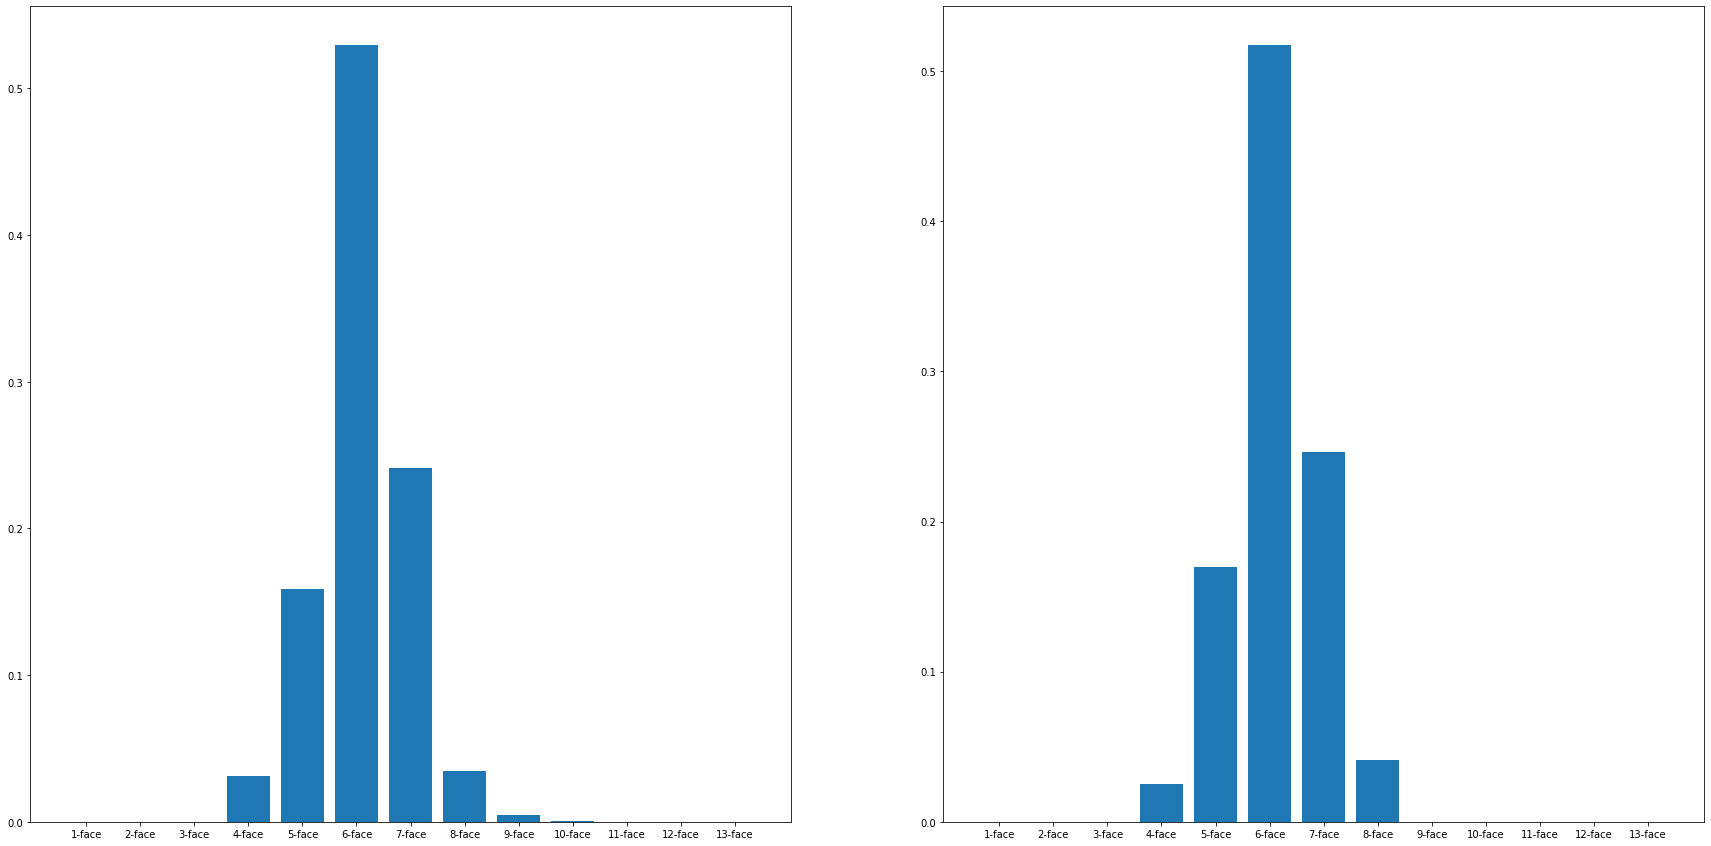

In [78]:
prediction_count_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
real_count_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(0, predictions.shape[0]):
    for j in range(0, len(np.round(predictions[i].detach().numpy(), 0))):
        prediction_count_list[j] += np.round(predictions[i].detach().numpy(), 0)[j]
        real_count_list[j] += out_data_test[i].detach().numpy()[j]
        
real_count_list.pop(0)
prediction_count_list.pop(0)

real_sum = 0
pred_sum = 0

for s in real_count_list:
    real_sum += s

for v in prediction_count_list:
    pred_sum += v

labels = [str(z)+'-face' for z in range(1,len(real_count_list)+1)]
real_data = [float(x/real_sum) for x in real_count_list]
pred_data = [float(x/pred_sum) for x in prediction_count_list]

fig, ax = plt.subplots(1,2,figsize=(30, 15))

ax[0].bar(labels, real_data, label='REAL')
ax[1].bar(labels, pred_data, label='PRED')

In [79]:
predictions = model(inp_data_train)

In [80]:
idx = np.random.randint(0, predictions.shape[0])
print('Prediction :', np.round(predictions[idx].detach().numpy(), 0))
print('Real output:', out_data_train[idx].detach().numpy())

Prediction : [12.  0.  0.  0.  1.  3.  5.  3.  1.  0.  0.  0.  0.  0.]
Real output: [13.  0.  0.  0.  0.  5.  2.  6.  0.  0.  0.  0.  0.  0.]


<BarContainer object of 13 artists>

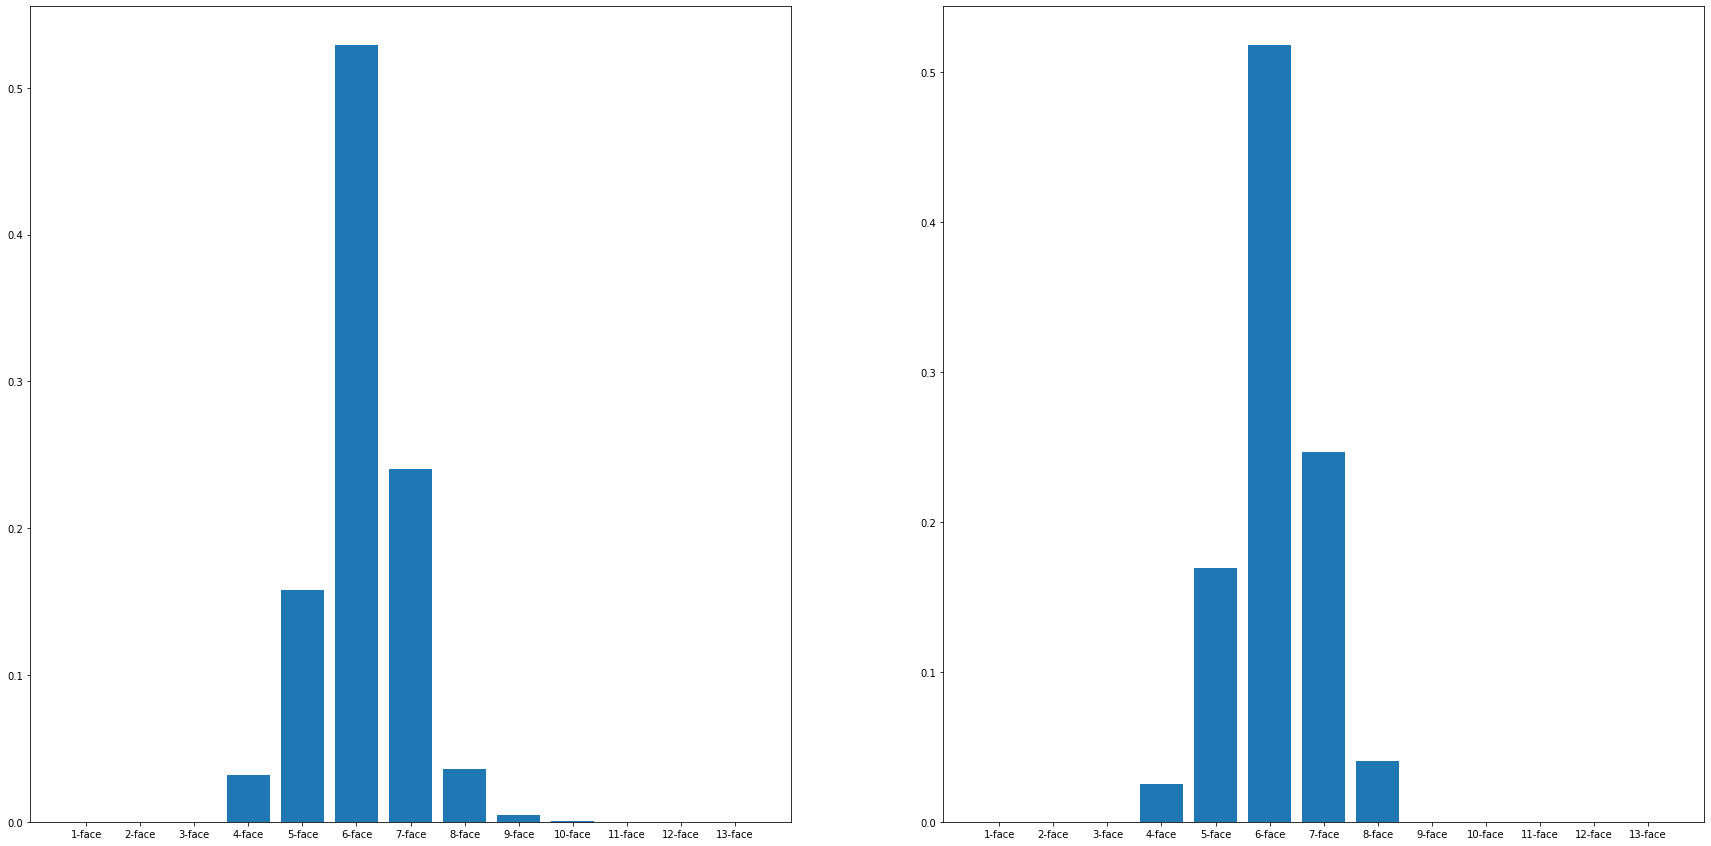

In [81]:
prediction_count_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
real_count_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(0, predictions.shape[0]):
    for j in range(0, len(np.round(predictions[i].detach().numpy(), 0))):
        prediction_count_list[j] += np.round(predictions[i].detach().numpy(), 0)[j]
        real_count_list[j] += out_data_train[i].detach().numpy()[j]
        
real_count_list.pop(0)
prediction_count_list.pop(0)

real_sum = 0
pred_sum = 0

for s in real_count_list:
    real_sum += s

for v in prediction_count_list:
    pred_sum += v

labels = [str(z)+'-face' for z in range(1,len(real_count_list)+1)]
real_data = [float(x/real_sum) for x in real_count_list]
pred_data = [float(x/pred_sum) for x in prediction_count_list]

fig, ax = plt.subplots(1,2,figsize=(30, 15))

ax[0].bar(labels, real_data, label='REAL')
ax[1].bar(labels, pred_data, label='PRED')

In [75]:
model_scripted = torch.jit.script(model)
model_scripted.save('sutovoro_torch_model_scripted.pt')